In [4]:
import numpy as np
import matplotlib.pyplot as plt
from game import Game

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# define actions
actions = ('left', 'down', 'right', 'up')


def print_policy():
    policy = [agent(s).argmax(1)[0].detach().item() for s in range(state_space)]
    policy = np.asarray([actions[action] for action in policy])
    policy = policy.reshape((game.max_row, game.max_col))
    print("\n\n".join('\t'.join(line) for line in policy)+"\n")
    
# define Q-Network
class QNetwork(nn.Module):

    def __init__(self, state_space, action_space):
        super(QNetwork, self).__init__()
        # TODO YOUR CODE HERE - simple network
        self.fc1 = torch.nn.Linear(in_features=state_space, out_features=state_space)
        self.fc2 = torch.nn.Linear(in_features=state_space, out_features=action_space) 
        self.state_space = state_space

    def forward(self, x):
        x = self.one_hot_encoding(x)
        # TODO YOUR CODE HERE
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
        
    def one_hot_encoding(self, x):
        '''
        One-hot encodes the input data, based on the defined state_space.
        '''
        out_tensor = torch.zeros([1, state_space])
        out_tensor[0][x] = 1
        return out_tensor

loss and reward:  0 tensor(0.0159, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  100 tensor(0.0043, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  200 tensor(0.0000, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  300 tensor(0.0002, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  400 tensor(0.0005, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  500 tensor(0.0003, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  600 tensor(0.0042, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  700 tensor(0.0001, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  800 tensor(0.0000, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  900 tensor(0.0000, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  1000 tensor(0.0000, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  1100 tensor(2.0224e-07, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  1200 tensor(0.0001, grad_fn=<SmoothL1LossBackward>) -0.07
loss and reward:  13

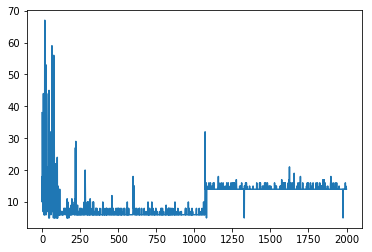

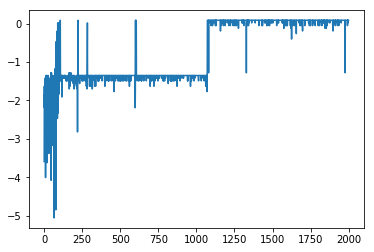

In [5]:
# Make use of cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# WHY LIVING PENALTY == -0.07
# The living penalty rewards the duration of the game. 
# Hence, setting the reward to a negative number incentivizes the algorithm to minimize the duration of the game
# and consequently optimizes for the shortest path, i.e. the path with the fewest steps, to the end (G).

# Init Game Instance
game = Game(living_penalty=-0.07, render=False)

# Define State and Action Space
state_space = game.max_row * game.max_col
action_space = len(actions)

# Set learning parameters
e = 0.1  # epsilon
lr = .03  # learning rate
y = .999  # discount factor
num_episodes = 2000

# create lists to contain total rewards and steps per episode
jList = []
rList = []

# init Q-Network
agent = QNetwork(state_space, action_space).to(device)

# define optimizer and loss
# optimizer = optim.SGD(agent.parameters(), lr=lr)
optimizer = optim.Adam(params=agent.parameters())
criterion = nn.SmoothL1Loss()

for i in range(num_episodes):
    # Reset environment and get first new observation
    s = game.reset()
    rAll = 0
    j = 0

    # The Q-Network learning algorithm
    while j < 99:
        j += 1

        # Choose an action by greedily (with e chance of random action) from the Q-network
        with torch.no_grad():
            # TODO YOUR CODE HERE
            # Do a feedforward pass for the current state s to get predicted Q-values
            # for all actions and use the max as action a: max_a Q(s, a)
            a = torch.argmax(agent(s)).item()
            

        # e greedy exploration
        if np.random.rand(1) < e:
            a = np.random.randint(1, 4)

        # Get new state and reward from environment
        # TODO YOUR CODE HERE
        r, s1, game_over = game.perform_action(actions[a])
        
        # perform action to get reward r, next state s1 and game_over flag
        # calculate maximum overall network outputs: max_a’ Q(s1, a’).
        a1 = agent(s1)
        

        # Calculate Q and target Q
        q = agent(s).max(1)[0].view(1, 1)
        

        with torch.no_grad():
            # TODO YOUR CODE HERE
            # Set target Q-value for action to: r + y max_a’ Q(s’, a’)
            target_q = r + y*torch.max(a1).view(1,1)
            


        # print(q, target_q)
        # Calculate loss
        loss = criterion(q, target_q)
        if j == 1 and i % 100 == 0:
            print("loss and reward: ", i, loss, r)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Add reward to list
        rAll += r

        # Replace old state with new
        s = s1

        if game_over:
            # Reduce chance of random action as we train the model.
            e = 1./((i/50) + 10)
            break
    rList.append(rAll)
    jList.append(j)
    
print("\Average steps per episode: " + str(sum(jList)/num_episodes))
print("\nScore over time: " + str(sum(rList)/num_episodes))
print("\nFinal Q-Network Policy:\n")
print_policy()
plt.plot(jList)
plt.savefig("j_q_network.png")
plt.show()
plt.plot(rList)
plt.show()